In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
data_dir = "data/dataset_defectos"
categorias = ["mancha","motita"]
augmented_dir = "data/dataset_defectos_aumentado"

In [3]:
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
    for category in categorias:
        os.makedirs(os.path.join(augmented_dir, category))

In [4]:
# Parámetros
target_size = (224, 224)
batch_size = 32
num_augmented_images = {"mancha": 20, "motita": 20}

In [5]:
augmentor = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

for category in categorias:
    input_folder = os.path.join(data_dir, category)
    output_folder = os.path.join(augmented_dir, category)

    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        i = 0
        for batch in augmentor.flow(
            img_array,
            batch_size=1,
            save_to_dir=output_folder,
            save_prefix="aug",
            save_format="jpeg"
        ):
            i += 1
            if i >= num_augmented_images[category]:
                break

In [6]:
gen_defectos = ImageDataGenerator(validation_split=0.2, rescale=1.0/255)

train_defectos = gen_defectos.flow_from_directory(
    augmented_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_defectos = gen_defectos.flow_from_directory(
    augmented_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3775 images belonging to 2 classes.
Found 943 images belonging to 2 classes.


In [7]:
X_val_def, y_val_def = [], []
for i in range(len(val_defectos)):
    x_batch, y_batch = val_defectos[i]
    X_val_def.extend(x_batch)
    y_val_def.extend(y_batch)

X_val_def = np.array(X_val_def)
y_val_def = np.array(y_val_def)

In [8]:
base_defectos = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_defectos.trainable = True
for layer in base_defectos.layers[:140]:
    layer.trainable = False

In [9]:
x = base_defectos.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
out = Dense(len(categorias), activation='softmax')(x)

modelo_defectos = Model(inputs=base_defectos.input, outputs=out)

In [10]:
modelo_defectos.compile(optimizer=keras.optimizers.AdamW(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
modelo_defectos.fit(train_defectos, validation_data=val_defectos, epochs=70, callbacks=[early_stopping])
modelo_defectos.save("models/modelo_defectos.keras")
print("Modelo de defectos entrenado y guardado.")

Epoch 1/70
118/118 [==============================] - 41s 263ms/step - loss: 0.6833 - accuracy: 0.5828 - val_loss: 0.6827 - val_accuracy: 0.5769
Epoch 2/70
118/118 [==============================] - 22s 186ms/step - loss: 0.5531 - accuracy: 0.7264 - val_loss: 0.6025 - val_accuracy: 0.6829
Epoch 3/70
118/118 [==============================] - 23s 191ms/step - loss: 0.4775 - accuracy: 0.7875 - val_loss: 0.5433 - val_accuracy: 0.7200
Epoch 4/70
118/118 [==============================] - 23s 197ms/step - loss: 0.4271 - accuracy: 0.8283 - val_loss: 0.4899 - val_accuracy: 0.7519
Epoch 5/70
118/118 [==============================] - 23s 192ms/step - loss: 0.3826 - accuracy: 0.8456 - val_loss: 0.4568 - val_accuracy: 0.7720
Epoch 6/70
118/118 [==============================] - 24s 202ms/step - loss: 0.3410 - accuracy: 0.8654 - val_loss: 0.4157 - val_accuracy: 0.8038
Epoch 7/70
118/118 [==============================] - 22s 187ms/step - loss: 0.2973 - accuracy: 0.8940 - val_loss: 0.3813 - val_ac

2025-04-16 00:41:52.423264: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 567791616 exceeds 10% of free system memory.
2025-04-16 00:41:53.109906: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 567791616 exceeds 10% of free system memory.


30/30 [==============================] - 3s 70ms/step


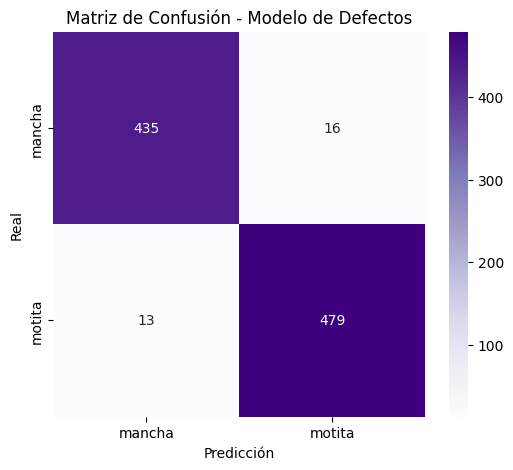

              precision    recall  f1-score   support

      mancha       0.97      0.96      0.97       451
      motita       0.97      0.97      0.97       492

    accuracy                           0.97       943
   macro avg       0.97      0.97      0.97       943
weighted avg       0.97      0.97      0.97       943



In [12]:
model = keras.models.load_model("models/modelo_defectos.keras")

y_pred_def = np.argmax(modelo_defectos.predict(X_val_def), axis=1)
y_true_def = np.argmax(y_val_def, axis=1)

cm = confusion_matrix(y_true_def, y_pred_def)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=categorias, yticklabels=categorias)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo de Defectos")
plt.show()

print(classification_report(y_true_def, y_pred_def, target_names=categorias))